<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 3
Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 10
## <center> Прогнозирование задержек вылетов

Ваша задача – побить как минимум 2 бенчмарка в [соревновании](https://www.kaggle.com/c/flight-delays-spring-2018) на Kaggle Inclass. Подробных инструкций не будет, будет только тезисно описано, как получен второй – с помощью Xgboost. Надеюсь, на данном этапе курса вам достаточно бросить полтора взгляда на данные, чтоб понять, что это тот тип задачи, в которой затащит градиентный бустинг. Скорее всего Xgboost, но тут у нас еще немало категориальных признаков...

<img src='../../img/xgboost_meme.jpg' width=40% />

In [1]:
import os
os.environ['JOBLIB_TEMP_FOLDER']="/tmp"

In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

In [3]:
train = pd.read_csv('../../data/flight_delays_train.csv')
test = pd.read_csv('../../data/flight_delays_test.csv')

In [4]:
len(train), len(test)

(100000, 100000)

In [5]:
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [6]:
test.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
0,c-7,c-25,c-3,615,YV,MRY,PHX,598
1,c-4,c-17,c-2,739,WN,LAS,HOU,1235
2,c-12,c-2,c-7,651,MQ,GSP,ORD,577
3,c-3,c-25,c-7,1614,WN,BWI,MHT,377
4,c-6,c-6,c-3,1505,UA,ORD,STL,258


In [7]:
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline

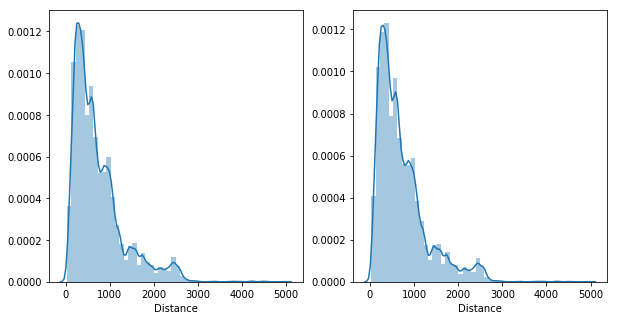

In [8]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
sns.distplot(train["Distance"])
plt.subplot(122)
sns.distplot(test["Distance"])

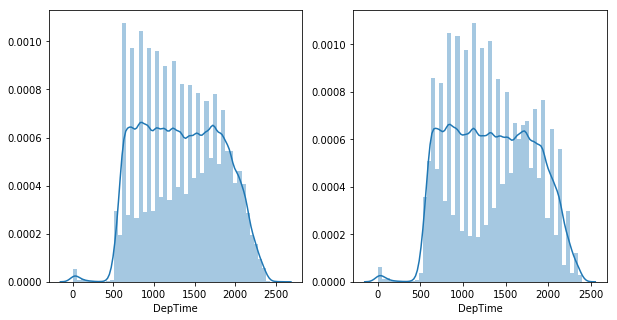

In [9]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
sns.distplot(train["DepTime"])
plt.subplot(122)
sns.distplot(test["DepTime"])

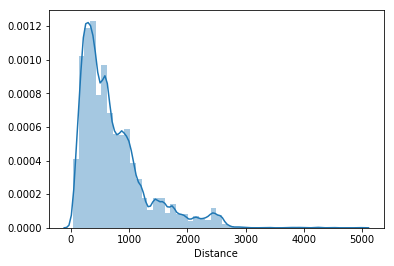

In [10]:
sns.distplot(test["Distance"])

In [11]:
unique_carriers = np.concatenate([train['UniqueCarrier'].unique(), test['UniqueCarrier'].unique()])
len(unique_carriers)

42

In [12]:
set(train['Origin'].unique()) - set(test['Origin'].unique())

{'CDC', 'HKY', 'HVN', 'ISO', 'PIE', 'VCT', 'VIS'}

In [13]:
set(train['UniqueCarrier'].unique()) - set(test['UniqueCarrier'].unique())

{'DH', 'HP', 'TZ'}

In [14]:
train[train['dep_delayed_15min'] == "Y"]['UniqueCarrier'].value_counts()

WN    3219
AA    1770
MQ    1448
DL    1373
UA    1322
OO    1277
US    1085
EV    1082
NW    1075
XE    1026
OH     808
CO     788
FL     736
AS     541
YV     478
B6     393
HP     196
DH     156
F9     156
TZ      64
HA      33
AQ      18
Name: UniqueCarrier, dtype: int64

In [15]:
train[train['dep_delayed_15min'] == "Y"]['Origin'].value_counts()

ATL    1506
ORD    1254
DFW     902
DEN     575
LAX     552
LAS     546
EWR     538
IAH     492
PHX     491
DTW     401
PHL     388
MSP     362
SFO     360
CVG     360
LGA     350
MDW     343
BOS     332
JFK     332
MCO     326
SEA     322
SLC     304
CLT     288
IAD     284
BWI     282
SAN     213
OAK     211
MIA     207
TPA     202
FLL     192
DCA     190
       ... 
SCC       2
OME       2
SGU       2
RST       2
YAK       2
GGG       1
ACK       1
ERI       1
FLO       1
ISO       1
BGM       1
CDV       1
GST       1
MQT       1
ACY       1
SJT       1
BTM       1
BPT       1
GTF       1
HTS       1
HLN       1
TEX       1
GTR       1
EKO       1
SCE       1
ADK       1
CWA       1
BLI       1
CDC       1
BRO       1
Name: Origin, Length: 269, dtype: int64

Итак, надо по времени вылета самолета, коду авиакомпании-перевозчика, месту вылета и прилета и расстоянию между аэропортами вылета и прилета предсказать задержку вылета более 15 минут. В качестве простейшего бенчмарка возьмем логистическую регрессию и два признака, которые проще всего взять: `DepTime` и `Distance`. У такой модели результат – 0.68202 на LB. 

In [8]:
X_train, y_train = train[['Distance', 'DepTime']].values, train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_test = test[['Distance', 'DepTime']].values

X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=17)

scaler = StandardScaler()
X_train_part = scaler.fit_transform(X_train_part)
X_valid = scaler.transform(X_valid)

In [9]:
logit = LogisticRegression()

logit.fit(X_train_part, y_train_part)
logit_valid_pred = logit.predict_proba(X_valid)[:, 1]

roc_auc_score(y_valid, logit_valid_pred)

0.6795691465352607

In [11]:
import xgboost as xgb

In [18]:
dtrain = xgb.DMatrix(X_train_part, label=y_train_part)
dval = xgb.DMatrix(X_valid, label=y_valid)

params = {
    'booster': 'gbtree',
    'colsample_bytree': 0.8,
    'eta': 0.03,
    'eval_metric': 'auc',
    'max_depth': 8,
    'objective': 'binary:logistic',
    'seed': 5896,
    'silent': 1,
    'subsample': 0.9,
    'tree_method': 'auto'
}

xgbmodel = xgb.train(params, dtrain, num_boost_round=1500, evals=[(dval,'test'), ], early_stopping_rounds=50, verbose_eval=25)

[0]	test-auc:0.688302
Will train until test-auc hasn't improved in 50 rounds.
[25]	test-auc:0.692452
[50]	test-auc:0.69304
[75]	test-auc:0.694018
[100]	test-auc:0.693941
[125]	test-auc:0.694222
[150]	test-auc:0.694394
[175]	test-auc:0.694478
[200]	test-auc:0.694544
[225]	test-auc:0.694603
[250]	test-auc:0.694637
[275]	test-auc:0.694594
Stopping. Best iteration:
[234]	test-auc:0.694637



In [21]:
logit_valid_pred = xgbmodel.predict(xgb.DMatrix(X_valid))
roc_auc_score(y_valid, logit_valid_pred)

0.6946111817052031

In [28]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
xgbmodel = xgb.train(params, dtrain, num_boost_round=234)

In [29]:
xgb_test_pred = xgbmodel.predict(xgb.DMatrix(X_test_scaled))

pd.Series(xgb_test_pred, name='dep_delayed_15min').to_csv('xgb_2feat.csv', index_label='id', header=True)